In [1]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
#import deepretina.visualizations as viz
from preprocessing import datagen, loadexpt
from utils import rolling_window
#from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load white noise data

In [2]:
whitenoise_train = loadexpt(0, 'whitenoise', 'train', 40, roll=False)

Loading training data... Done.


In [2]:
import preprocessing

In [3]:
import os
f = h5py.File(os.path.join(preprocessing.datadirs['lane.local'], '15-10-07/whitenoise.h5'), 'r')

In [4]:
spk = f['spikes/cell01']

In [5]:
len(spk)

25761

In [7]:
f['train/time'].shape

(359802,)

In [8]:
time = np.array(f['train/time'])
sta, tax = ft.getsta(time, whitenoise_train.X, spk, 40)

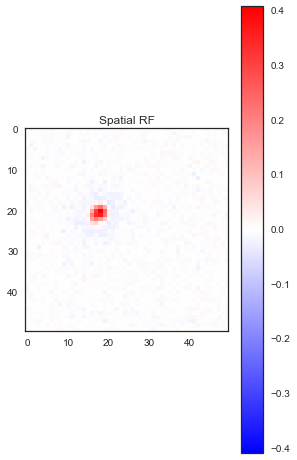

(<matplotlib.figure.Figure at 0x118cf1390>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x118cf1b90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x118d0c5d0>))

In [9]:
pyviz.plotsta(tax, sta)

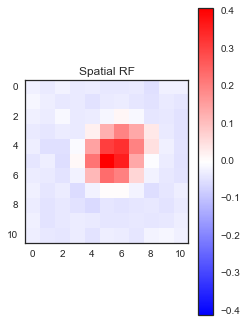

(<matplotlib.figure.Figure at 0x11a28b6d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11a28bc10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x118d0a050>))

In [10]:
pyviz.plotsta(tax, ft.cutout(sta, idx=np.flipud(ft.filterpeak(sta)[1]), width=5))

In [11]:
Xcut = ft.cutout(whitenoise_train.X, idx=np.flipud(ft.filterpeak(sta)[1]), width=5)

In [12]:
Xcut[:100].shape

(100, 11, 11)

In [13]:
Xcut.dtype

dtype('float32')

In [14]:
import scipy
scipy.__version__

'0.16.1'

In [15]:
from scipy.linalg.blas import get_blas_funcs

In [16]:
outer = get_blas_funcs('syr',dtype='d')

In [22]:
0.5 * np.outer(np.arange(5), np.arange(5)) + np.eye(5)

array([[ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1.5,  1. ,  1.5,  2. ],
       [ 0. ,  1. ,  3. ,  3. ,  4. ],
       [ 0. ,  1.5,  3. ,  5.5,  6. ],
       [ 0. ,  2. ,  4. ,  6. ,  9. ]])

In [23]:
outer(0.5, np.arange(5), a=np.eye(5))

array([[ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1.5,  1. ,  1.5,  2. ],
       [ 0. ,  0. ,  3. ,  3. ,  4. ],
       [ 0. ,  0. ,  0. ,  5.5,  6. ],
       [ 0. ,  0. ,  0. ,  0. ,  9. ]])

In [26]:
x = np.random.randn(10000, 10, 10)
t = np.linspace(0, 100, x.shape[0])
s = np.random.rand(200) * 100

In [36]:
%%time
stc0 = ft.getstc(t, x, s, 50)

CPU times: user 13.8 s, sys: 12.5 s, total: 26.3 s
Wall time: 26.3 s


In [37]:
%%time
ste = ft.getste(t, x, s, 50)
stc = np.zeros((5000, 5000))
for si in ste:
    sr = si.ravel()
    stc += np.outer(sr, sr)

CPU times: user 17.6 s, sys: 12.1 s, total: 29.6 s
Wall time: 29.6 s


In [113]:
stc = np.zeros((35*11*11, 35*11*11))
for idx, s in enumerate(ft.getste(time, Xcut, spk, 35)):
    sr = s.astype('float').ravel()
    if sr.size == (35*11*11):
        stc += np.outer(sr, sr)
        
    if idx % 500 == 0:
        print('{}'.format(100.*idx/len(spk)))

0.0
1.94091844261
3.88183688521
5.82275532782
7.76367377043
9.70459221304
11.6455106556
13.5864290982
15.5273475409
17.4682659835
19.4091844261
21.3501028687
23.2910213113
25.2319397539
27.1728581965
29.1137766391
31.0546950817
32.9956135243
34.9365319669
36.8774504095
38.8183688521
40.7592872947
42.7002057374
44.64112418
46.5820426226
48.5229610652
50.4638795078
52.4047979504
54.345716393
56.2866348356
58.2275532782
60.1684717208
62.1093901634
64.050308606
65.9912270486
67.9321454912
69.8730639339
71.8139823765
73.7549008191
75.6958192617
77.6367377043
79.5776561469
81.5185745895
83.4594930321
85.4004114747
87.3413299173
89.2822483599
91.2231668025


In [ ]:
stc_normalized = stc/len(spk)
#stc_normalized -= np.outer(sta.ravel(), sta.ravel())
hist(np.diag(stc_normalized))

In [ ]:
u,v = np.linalg.eigh(stc_normalized)